In [1]:
#import modules
%matplotlib inline

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from urllib.request import urlopen 


plt.style.use('ggplot')
pd.set_option('display.max_columns', 500) 

# LOAD DATA

load data into panda dataframe

In [2]:
breast_cancer = pd.read_csv("data.csv")

In [3]:
names = ['id', 'diagnosis', 'radius_mean', 
         'texture_mean', 'perimeter_mean', 'area_mean', 
         'smoothness_mean', 'compactness_mean', 
         'concavity_mean','concave_points_mean', 
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se', 
         'area_se', 'smoothness_se', 'compactness_se', 
         'concavity_se', 'concave_points_se', 
         'symmetry_se', 'fractal_dimension_se', 
         'radius_worst', 'texture_worst', 
         'perimeter_worst', 'area_worst', 
         'smoothness_worst', 'compactness_worst', 
         'concavity_worst', 'concave_points_worst', 
         'symmetry_worst', 'fractal_dimension_worst']

dx = ['Benign', 'Malignant']

# Cleaning:

In [4]:
# Setting 'id_number' as our index

breast_cancer.set_index(['id'], inplace=True)

# Converted to binary to help later on with models and plots

breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map({'M': 1, 'B': 0})
breast_cancer.diagnosis

id
842302      1
842517      1
84300903    1
84348301    1
84358402    1
           ..
926424      1
926682      1
926954      1
927241      1
92751       0
Name: diagnosis, Length: 569, dtype: int64

# Missing Values

In [5]:
breast_cancer.apply(lambda x: x.isnull().sum())

diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32                569
dtype: i

In [6]:
 #For later use in CART models
names_index = names[2:]

In [7]:
del breast_cancer['Unnamed: 32']

In [8]:
breast_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [9]:
print("Here's the dimensions of our data frame:\n", 
     breast_cancer.shape)
print("Here's the data types of our columns:\n",
     breast_cancer.dtypes)

Here's the dimensions of our data frame:
 (569, 31)
Here's the data types of our columns:
 diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64

In [10]:
breast_cancer.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


# Creating Training and Test Sets

In [11]:
feature_space = breast_cancer.iloc[:,breast_cancer.columns != 'diagnosis']
feature_class = breast_cancer.iloc[:,breast_cancer.columns == 'diagnosis']

training_set, test_set, class_set, test_class_set = train_test_split(feature_space,feature_class,test_size = 0.20,random_state = 42)

In [12]:
 # Cleaning test sets to avoid future warning messages
class_set = class_set.values.ravel() 
test_class_set = test_class_set.values.ravel() 

# Fitting Random Forest

In [13]:
fit_rf = RandomForestClassifier(random_state = 42)

# Hyperparameters Optimization

In [14]:
np.random.seed(42)
start = time.time()
param_dist = {'max_depth':[2,3,4],
              'bootstrap':[True,False],
              'max_features':['auto','sqrt','log2',None],
              'criterion': ['gini','entropy']}
cv_rf = GridSearchCV(fit_rf,cv=10,
                    param_grid = param_dist,
                    n_jobs = 3)
cv_rf.fit(training_set,class_set)

print('Best Parameters using grid search: \n', 
      cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2'}
Time taken in grid search:  35.89


Once we are given the best parameter combination, we set the parameters to our model.

Notice how we didn't utilize the bootstrap: True parameter, this will make sense in the following section.

In [15]:
# Set best parameters given by grid search 
fit_rf.set_params(criterion = 'entropy',
                  max_features = 'log2', 
                  max_depth = 4)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                       random_state=42)

# OOB Rate

In [16]:
fit_rf.set_params(warm_start=False, 
                  oob_score=True)

min_estimators = 15
max_estimators = 1000

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    fit_rf.set_params(n_estimators=i)
    fit_rf.fit(training_set,class_set)

    oob_error = 1 - fit_rf.oob_score_
    error_rate[i] = oob_error
    


In [17]:
# Convert dictionary to a pandas series for easy plotting 
oob_series = pd.Series(error_rate)

print(oob_series)

15      0.048352
16      0.039560
17      0.037363
18      0.037363
19      0.037363
          ...   
996     0.037363
997     0.037363
998     0.037363
999     0.037363
1000    0.037363
Length: 986, dtype: float64


Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

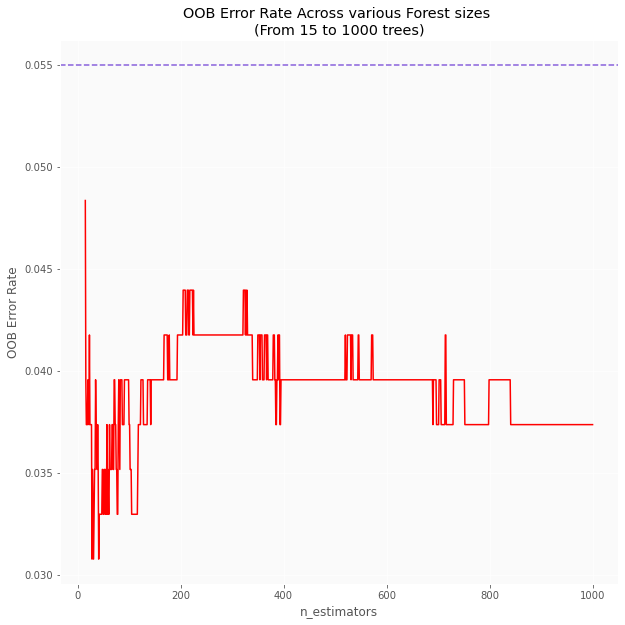

In [18]:
fig, ax =plt.subplots(figsize=(10,10))

ax.set_facecolor('#fafafa')
oob_series.plot(kind = 'line',
               color = 'red')
plt.axhline(0.055,
           color = '#875FDB',
           linestyle = '--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')




The OOB error rate starts to oscilate at around 400 trees, so I will go ahead and use my judgement to use 400 trees in my forest. Using the pandas series object I can easily find the OOB error rate for the estimator as follows:

In [19]:
print('OOB error rate for 400 tree is: {0:5f}'.format(oob_series[400]))

OOB error rate for 400 tree is: 0.039560


# Traditional Training and Test Set Split¶
In order for this methodology to work we will set the number of trees calculated using the OOB error rate, and removing the warm_start and oob_score parameters. Along with including the bootstrap parameter.

In [20]:
fit_rf.set_params(n_estimators = 400,
                 bootstrap = True,
                 warm_start = False,
                 oob_score = False)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                       n_estimators=400, random_state=42)

# Training Algorithm
Next we train the algorithm utilizing the training and target class set we had made earlier.

In [22]:
fit_rf.fit(training_set, class_set)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features='log2',
                       n_estimators=400, random_state=42)

# Variable Importance

In [23]:
def variable_importance(fit):
    try:
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 
                # Captures whether the model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        print("Model entered does not contain 'estimators_' attribute.")

    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [24]:
var_imp_rf = variable_importance(fit_rf)

importances_rf = var_imp_rf['importance']

indices_rf = var_imp_rf['index']

In [25]:
def print_var_importance(importance, indices, name_index):
    
    print("Feature ranking:")
    

    for f in range(0, indices.shape[0]):
        i = f
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1,
                      names_index[indices[i]],
                      importance[indices[f]]))


In [26]:
print_var_importance(importances_rf, indices_rf, names_index)

Feature ranking:
1. The feature 'area_worst' has a Mean Decrease in Impurity of 0.12603
2. The feature 'perimeter_worst' has a Mean Decrease in Impurity of 0.11260
3. The feature 'concave_points_worst' has a Mean Decrease in Impurity of 0.11156
4. The feature 'concave_points_mean' has a Mean Decrease in Impurity of 0.09233
5. The feature 'radius_worst' has a Mean Decrease in Impurity of 0.07561
6. The feature 'concavity_mean' has a Mean Decrease in Impurity of 0.05808
7. The feature 'area_mean' has a Mean Decrease in Impurity of 0.04866
8. The feature 'concavity_worst' has a Mean Decrease in Impurity of 0.04826
9. The feature 'radius_mean' has a Mean Decrease in Impurity of 0.04690
10. The feature 'perimeter_mean' has a Mean Decrease in Impurity of 0.04466
11. The feature 'area_se' has a Mean Decrease in Impurity of 0.04033
12. The feature 'texture_worst' has a Mean Decrease in Impurity of 0.02461
13. The feature 'compactness_worst' has a Mean Decrease in Impurity of 0.01990
14. The fe

In [27]:
def variable_importance_plot(importance, indices, name_index):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart
    was transposed and index would be in incorrect order.

    Parameters
    ----------
    * importance: Array returned from feature_importances_ for CART
                models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest
                based on feature_importances_
    * name_index: Name of columns included in model

    Returns:
    ----------
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    #ax.set_axis_bgcolor('#fafafa')
    plt.title('Feature importances for Random Forest Model\
    \nBreast Cancer (Diagnostic)')
    plt.barh(index,
             importance_desc,
             align="center",
             color = '#875FDB')
    plt.yticks(index,
               feature_space)

    plt.ylim(-1, 30)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Impurity')
    plt.ylabel('Feature')

    plt.show()
    plt.close()

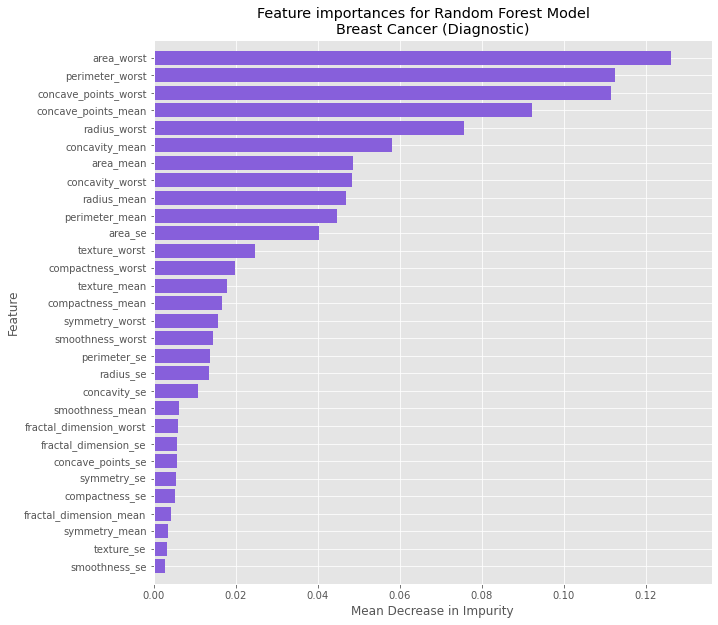

In [28]:
variable_importance_plot(importances_rf, indices_rf, names_index)

In [29]:
def cross_val_metrics(fit, training_set, class_set, estimator, print_results = True):
    """
    Purpose
    ----------
    Function helps automate cross validation processes while including 
    option to print metrics or store in variable

    Parameters
    ----------
    fit: Fitted model 
    training_set:  Data_frame containing 80% of original dataframe
    class_set:     data_frame containing the respective target vaues 
                      for the training_set
    print_results: Boolean, if true prints the metrics, else saves metrics as 
                      variables

    Returns
    ----------
    scores.mean(): Float representing cross validation score
    scores.std() / 2: Float representing the standard error (derived
                from cross validation score's standard deviation)
    """
    my_estimators = {
    'rf': 'estimators_',
    'nn': 'out_activation_',
    'knn': '_fit_method'
    }
    try:
        # Captures whether first parameter is a model
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Captures whether the model has been trained
        if not vars(fit)[my_estimators[estimator]]:
            return print("Model does not appear to be trained.")

    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
\nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    n = KFold(n_splits=10)
    scores = cross_val_score(fit, 
                         training_set, 
                         class_set, 
                         cv = n)
    if print_results:
        for i in range(0, len(scores)):
            print("Cross validation run {0}: {1: 0.3f}".format(i, scores[i]))
        print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})"\
              .format(scores.mean(), scores.std() / 2))
    else:
        return scores.mean(), scores.std() / 2

In [30]:
cross_val_metrics(fit_rf, 
                  training_set, 
                  class_set, 
                  'rf',
                  print_results = True)

Cross validation run 0:  1.000
Cross validation run 1:  0.957
Cross validation run 2:  0.935
Cross validation run 3:  0.935
Cross validation run 4:  0.957
Cross validation run 5:  0.978
Cross validation run 6:  0.978
Cross validation run 7:  0.933
Cross validation run 8:  1.000
Cross validation run 9:  0.933
Accuracy:  0.960 (+/-  0.013)


# Test Set Metrics

In [31]:
predictions_rf = fit_rf.predict(test_set)
print(predictions_rf)

[0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 0 1
 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 0 0 1 0 0 1
 0 0 1]


# Confusion Matrix

In [32]:
def create_conf_mat(test_class_set, predictions):
    """Function returns confusion matrix comparing two arrays"""
    if (len(test_class_set.shape) != len(predictions.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (test_class_set.shape != predictions.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = test_class_set,
                                        columns = predictions)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

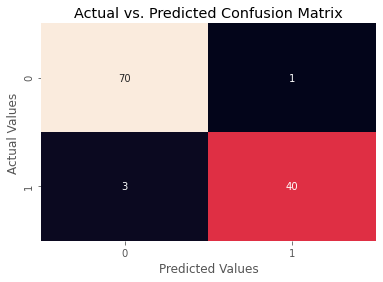

In [33]:
conf_mat = create_conf_mat(test_class_set, predictions_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [34]:
accuracy_rf = fit_rf.score(test_set, test_class_set)

print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_rf))

Here is our mean accuracy on the test set:
 0.965


In [35]:
# Here we calculate the test error rate!
test_error_rate_rf = 1 - accuracy_rf
print("The test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_rf))

The test error rate for our model is:
  0.0351


# ROC Curve Metrics

In [36]:
# We grab the second array from the output which corresponds to
# to the predicted probabilites of positive classes 
# Ordered wrt fit.classes_ in our case [0, 1] where 1 is our positive class
predictions_prob = fit_rf.predict_proba(test_set)[:, 1]

fpr2, tpr2, _ = roc_curve(test_class_set,
                          predictions_prob,
                          pos_label = 1)

In [37]:
auc_rf = auc(fpr2, tpr2)

In [38]:
def plot_roc_curve(fpr, tpr, auc, estimator, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph

    Parameters
    ----------
    * fpr: Array returned from sklearn.metrics.roc_curve for increasing
            false positive rates
    * tpr: Array returned from sklearn.metrics.roc_curve for increasing
            true positive rates
    * auc: Float returned from sklearn.metrics.auc (Area under Curve)
    * estimator: String represenation of appropriate model, can only contain the
    following: ['knn', 'rf', 'nn']
    * xlim: Set upper and lower x-limits
    * ylim: Set upper and lower y-limits
    """
    my_estimators = {'knn': ['Kth Nearest Neighbor', 'deeppink'],
              'rf': ['Random Forest', 'red'],
              'nn': ['Neural Network', 'purple']}

    try:
        plot_title = my_estimators[estimator][0]
        color_value = my_estimators[estimator][1]
    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
\nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
             color=color_value,
             linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f})'\
              .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    plt.close()

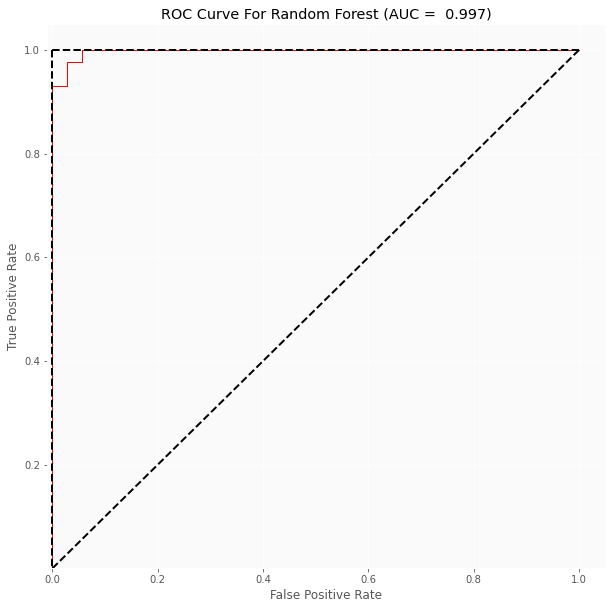

In [39]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf',
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

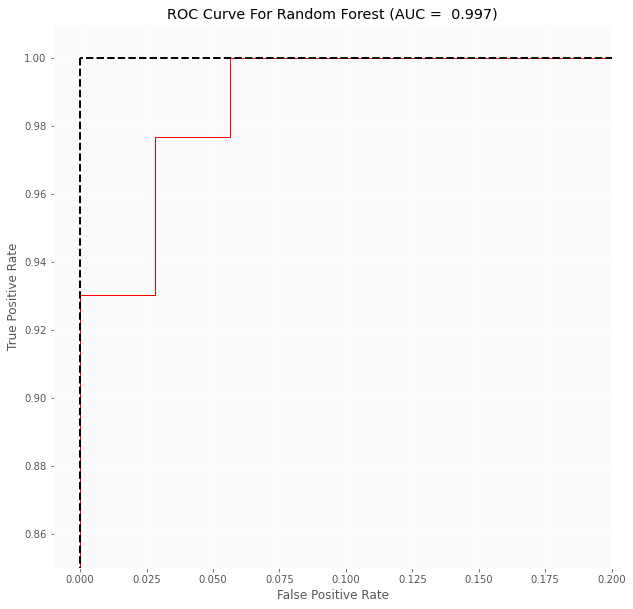

In [40]:
plot_roc_curve(fpr2, tpr2, auc_rf, 'rf', 
               xlim=(-0.01, 0.2), 
               ylim=(0.85, 1.01))

# Classification Report

In [41]:
def print_class_report(predictions, alg_name):
    """
    Purpose
    ----------
    Function helps automate the report generated by the
    sklearn package. Useful for multiple model comparison

    Parameters:
    ----------
    predictions: The predictions made by the algorithm used
    alg_name: String containing the name of the algorithm used
    
    Returns:
    ----------
    Returns classification report generated from sklearn. 
    """
    print('Classification Report for {0}:'.format(alg_name))
    print(classification_report(predictions, 
            test_class_set, 
            target_names = dx))

In [42]:
class_report = print_class_report(predictions_rf, 'Random Forest')

Classification Report for Random Forest:
              precision    recall  f1-score   support

      Benign       0.99      0.96      0.97        73
   Malignant       0.93      0.98      0.95        41

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

